In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GRU
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
folder_name = 's6'


ModuleNotFoundError: No module named 'tensorflow'

In [21]:
seed = 13520039
np.random.seed(seed)
tf.random.set_seed(seed)

In [22]:
conn = db.connect()

raw_data, colnames = db.get_data(conn)
conn.close()

In [23]:
train_data = pd.DataFrame(raw_data, columns=colnames)
train_data = train_data.clip(lower=0)
train_data.drop(["id", "timestamp"], axis=1, inplace=True)
colnames = train_data.columns

In [24]:
train_data.head()

,compose_post_service_cpu,compose_post_service_memory,home_timeline_redis_cpu,home_timeline_redis_memory,home_timeline_service_cpu,home_timeline_service_memory,jaeger_cpu,jaeger_memory,media_frontend_cpu,media_frontend_memory,...,user_mongodb_cpu,user_mongodb_memory,user_service_cpu,user_service_memory,user_timeline_mongodb_cpu,user_timeline_mongodb_memory,user_timeline_redis_cpu,user_timeline_redis_memory,user_timeline_service_cpu,user_timeline_service_memory
0,187.325286,14.125000,841.522299,1125.113281,93.077136,9.675781,11.934452,1175.468750,0.258233,14.570312,...,5.915370,119.585938,23.421181,13.59375,221.848020,373.351562,25.399166,63.730469,74.678976,19.625
1,1.165407,8.644531,519.415373,1029.875000,18.683592,9.675781,243.954576,1180.714844,0.000000,14.570312,...,6.440344,119.335938,6.625710,13.59375,78.791136,373.351562,7.985077,63.730469,23.110791,19.625
2,1.165272,8.644531,521.315932,1028.699219,0.002798,9.675781,231.991771,1180.714844,0.000000,14.570312,...,3.290788,119.335938,0.019184,13.59375,2.915703,373.351562,2.433058,63.406250,0.023231,19.625
3,0.003647,8.644531,4.186641,1028.699219,0.005046,9.675781,0.513094,1180.761719,0.000000,14.570312,...,3.820130,119.343750,0.034473,13.59375,8.852503,371.007812,4.178247,63.406250,0.023232,19.625
4,0.003648,8.644531,3.985567,1028.699219,0.007645,9.675781,0.513161,1180.761719,0.000000,14.570312,...,3.820626,119.343750,0.069254,13.59375,11.533481,371.007812,1.745297,63.406250,0.033578,19.625


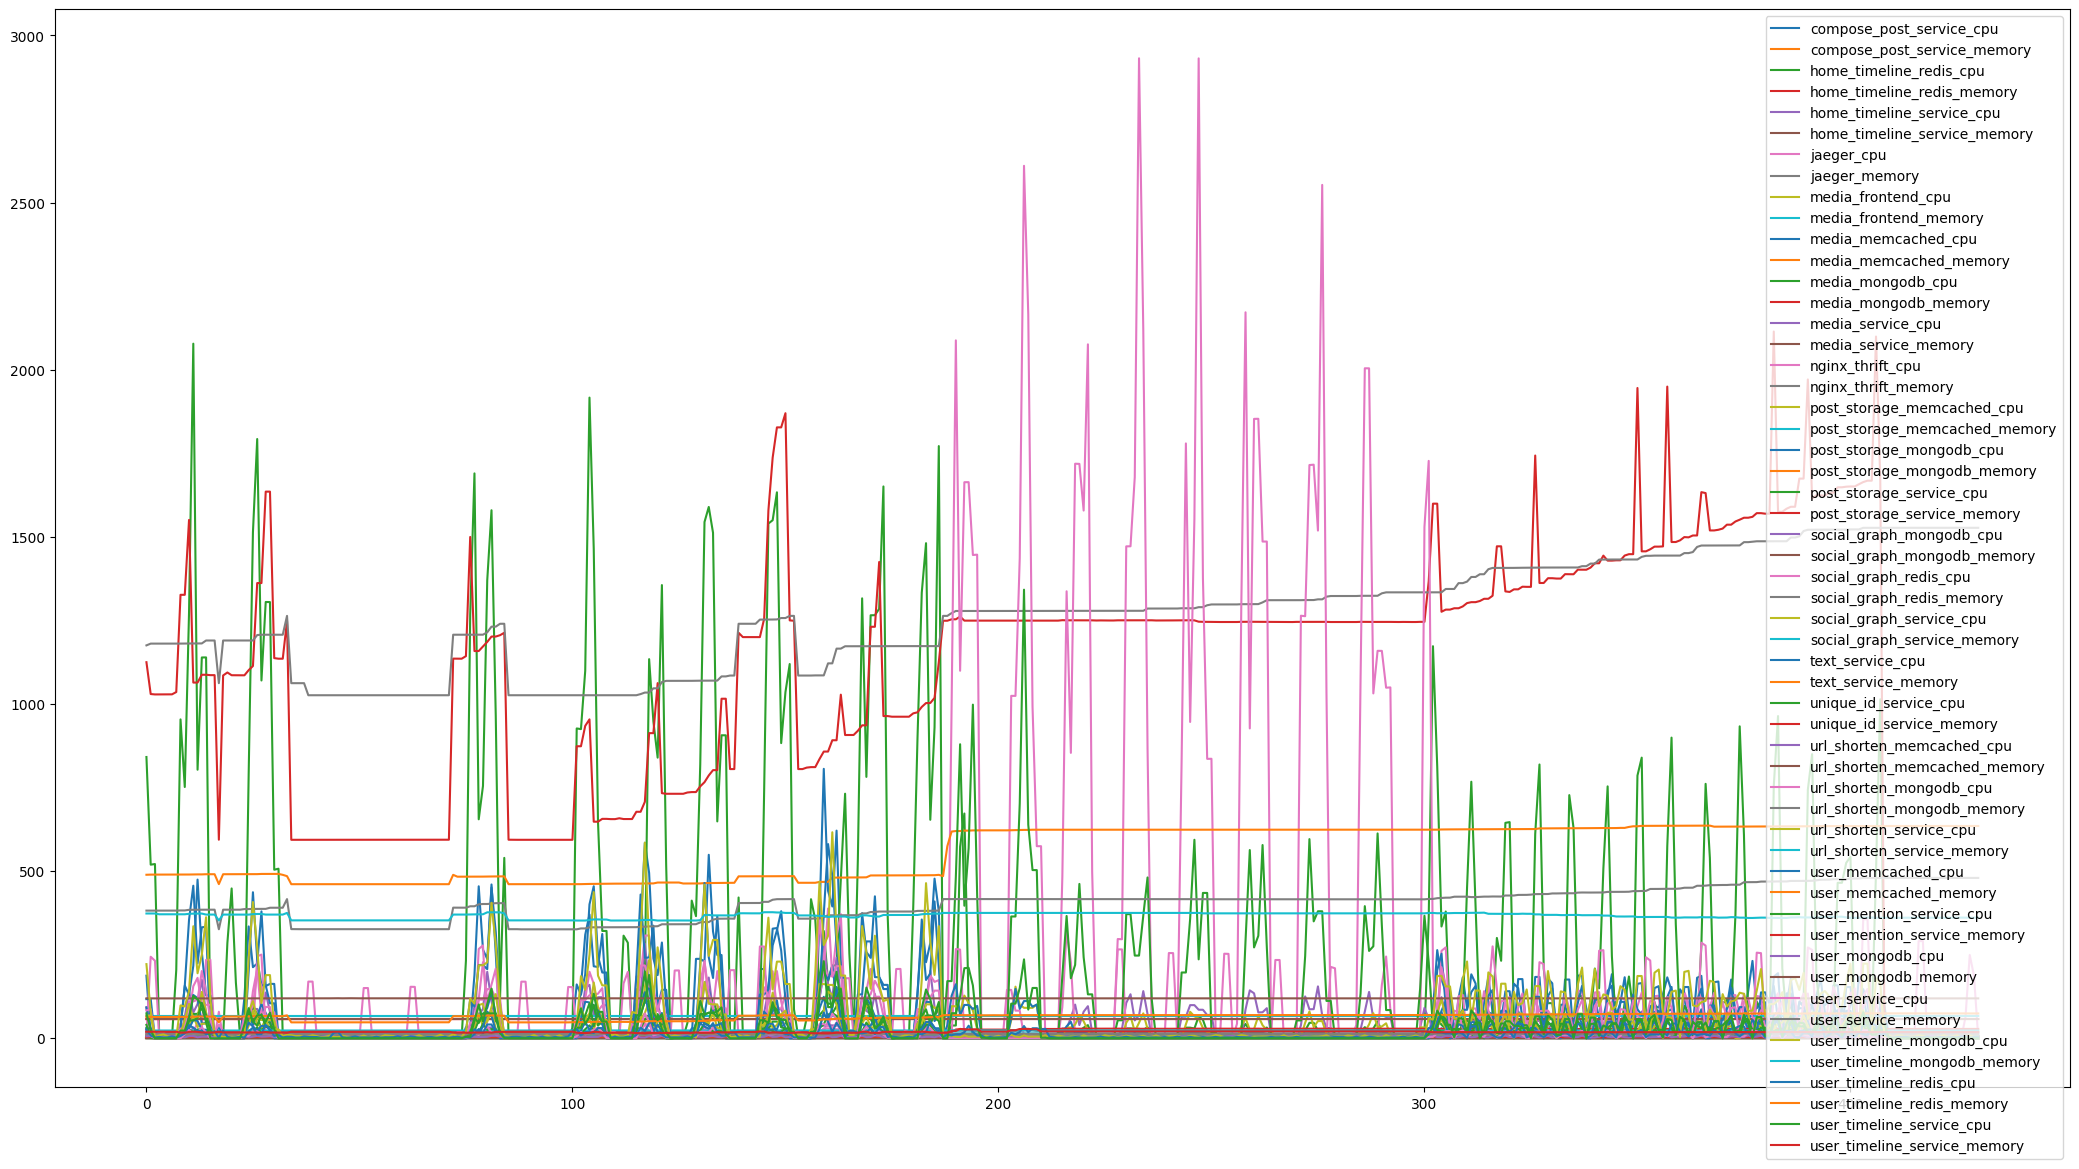

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(26, 14))
for col in train_data.columns:
    plt.plot(train_data[col], label=col)
plt.legend()
plt.show()


In [ ]:
train_data.shape

: 

In [27]:
import joblib 
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_data)
joblib.dump(sc, f'{folder_name}/minmax-scaler.pkl')

['s6/minmax-scaler.pkl']

In [28]:
# split for getting next timestep
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [29]:
# choose a number of time steps
n_steps = [30, 45, 60, 90, 120]
# split into samples
data = []
for res in n_steps:
    data.append(split_sequence(training_set_scaled, res))

print(len(data))

5


In [30]:
column_length = len(colnames)

In [31]:
data[2][0].shape

(371, 60, 54)

In [32]:
model_1_list = []
model_1_history_list = []
for i in range(len(n_steps)):
    model_1_list.append(Sequential())
    model_1_list[i].add(GRU(128, input_shape=(n_steps[i], len(colnames)), return_sequences=True))
    model_1_list[i].add(Dropout(0.2))
    model_1_list[i].add(GRU(64, return_sequences=True))
    model_1_list[i].add(Dropout(0.2))
    model_1_list[i].add(GRU(64))
    model_1_list[i].add(Dropout(0.2))
    model_1_list[i].add(Dense(48, activation='relu'))
    model_1_list[i].add(Dense(len(colnames)))

    model_1_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_1_history_list.append(model_1_list[i].fit(data[i][0], data[i][1], epochs=64, batch_size=32))
    print("============================== ^^ Model 1 Timestep: " + str(n_steps[i]))

Epoch 1/64
13/13 [==============================] - 2s 16ms/step - loss: 0.1212 - root_mean_squared_error: 0.3481
Epoch 2/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0754 - root_mean_squared_error: 0.2745
Epoch 3/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218
Epoch 4/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0397 - root_mean_squared_error: 0.1994
Epoch 5/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0358 - root_mean_squared_error: 0.1893
Epoch 6/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800
Epoch 7/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741
Epoch 8/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687
Epoch 9/64
13/13 [==============================] - 0s 15ms/step - loss: 0.0274 - root_m

In [34]:
model_2_list = []
model_2_history_list = []
for i in range(len(n_steps)):
    model_2_list.append(Sequential())
    model_2_list[i].add(LSTM(128, input_shape=(n_steps[i], len(colnames)), return_sequences=True))
    model_2_list[i].add(Dropout(0.1))
    model_2_list[i].add(LSTM(64, input_shape=(n_steps[i], len(colnames))))
    model_2_list[i].add(Dropout(0.1))
    model_2_list[i].add(Dense(48, activation='relu'))
    model_2_list[i].add(Dense(len(colnames)))

    model_2_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_2_history_list.append(model_2_list[i].fit(data[i][0], data[i][1], epochs=64, batch_size=32))
    print("============================== ^^ Model 2 Timestep: " + str(n_steps[i]))

Epoch 1/64
13/13 [==============================] - 2s 13ms/step - loss: 0.1060 - root_mean_squared_error: 0.3256
Epoch 2/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0716 - root_mean_squared_error: 0.2675
Epoch 3/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207
Epoch 4/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0361 - root_mean_squared_error: 0.1900
Epoch 5/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0315 - root_mean_squared_error: 0.1774
Epoch 6/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0289 - root_mean_squared_error: 0.1701
Epoch 7/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0280 - root_mean_squared_error: 0.1674
Epoch 8/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0271 - root_mean_squared_error: 0.1645
Epoch 9/64
13/13 [==============================] - 0s 13ms/step - loss: 0.0259 - root_m

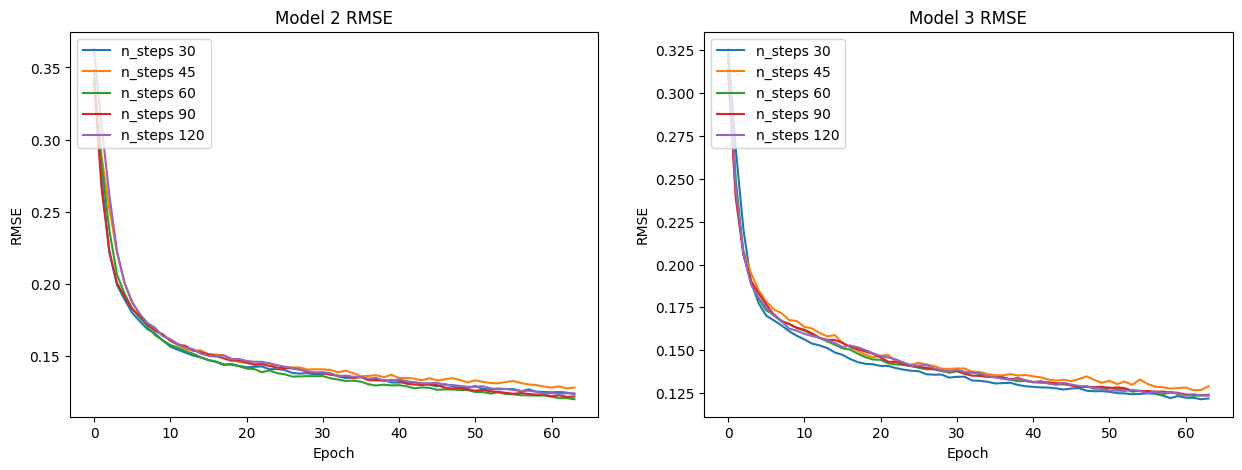

In [35]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(len(n_steps)):
    axs[0].plot(model_1_history_list[i].history['root_mean_squared_error'])
    axs[0].set_title('Model 2 RMSE')
    axs[0].set_ylabel('RMSE')
    axs[0].set_xlabel('Epoch')
    axs[0].legend([f'n_steps {n}' for n in n_steps], loc='upper left')

for i in range(len(n_steps)):
    axs[1].plot(model_2_history_list[i].history['root_mean_squared_error'])
    axs[1].set_title('Model 3 RMSE')
    axs[1].set_ylabel('RMSE')
    axs[1].set_xlabel('Epoch')
    axs[1].legend([f'n_steps {n}' for n in n_steps], loc='upper left')

plt.show()


In [36]:
list(map(lambda x: x.history['root_mean_squared_error'][-1], model_1_history_list))


[0.12366604804992676,
 0.12824459373950958,
 0.12010673433542252,
 0.12198973447084427,
 0.12418289482593536]

In [37]:
list(map(lambda x: x.history['root_mean_squared_error'][-1], model_2_history_list))


[0.1218312606215477,
 0.12900301814079285,
 0.1241166740655899,
 0.12364912033081055,
 0.12365922331809998]

In [38]:
data[3][0][-1:]

array([[[1.47686021e-01, 8.81014304e-02, 1.00430669e-01, ...,
         9.06241054e-01, 2.61789141e-01, 2.58475804e-01],
        [7.53365879e-02, 3.28348505e-02, 7.19649787e-02, ...,
         9.06241054e-01, 3.21758923e-02, 2.55578093e-01],
        [7.53511697e-02, 3.28348505e-02, 2.44372603e-01, ...,
         9.03521328e-01, 1.62930628e-01, 2.85424515e-01],
        ...,
        [6.50708127e-06, 4.61638492e-02, 5.59458870e-04, ...,
         9.78385342e-01, 1.50426029e-04, 2.84265430e-01],
        [1.17719840e-06, 4.61638492e-02, 8.10033781e-04, ...,
         9.78385342e-01, 1.56118999e-04, 2.84265430e-01],
        [4.40037015e-06, 4.61638492e-02, 1.34039597e-03, ...,
         9.78385342e-01, 2.83470508e-05, 2.84265430e-01]]])

In [39]:
data[1][0][-1:]

array([[[1.24929717e-01, 5.36410923e-02, 2.93452348e-02, ...,
         9.75808760e-01, 1.86702113e-01, 2.94697189e-01],
        [2.20621910e-01, 2.34070221e-02, 4.98378929e-02, ...,
         9.75808760e-01, 2.81593156e-01, 2.84265430e-01],
        [9.56971035e-02, 2.34070221e-02, 2.04938643e-02, ...,
         9.54480389e-01, 1.01334903e-01, 2.85424515e-01],
        ...,
        [6.50708127e-06, 4.61638492e-02, 5.59458870e-04, ...,
         9.78385342e-01, 1.50426029e-04, 2.84265430e-01],
        [1.17719840e-06, 4.61638492e-02, 8.10033781e-04, ...,
         9.78385342e-01, 1.56118999e-04, 2.84265430e-01],
        [4.40037015e-06, 4.61638492e-02, 1.34039597e-03, ...,
         9.78385342e-01, 2.83470508e-05, 2.84265430e-01]]])

In [40]:
current_data = data[1][0][-1:]
predicted_data = []
for i in range(6):
    new_data = model_1_list[1].predict(current_data, verbose=0)
    transformed_new_data = sc.inverse_transform(new_data)[0]
    predicted_data.append(transformed_new_data)
    data_len = len(current_data[0])
    current_data = np.append(current_data[0][1:], new_data[0]).reshape(1, data_len, len(colnames))

In [41]:
df_predicted = pd.DataFrame(predicted_data, columns=colnames)

In [42]:
df_predicted

,compose_post_service_cpu,compose_post_service_memory,home_timeline_redis_cpu,home_timeline_redis_memory,home_timeline_service_cpu,home_timeline_service_memory,jaeger_cpu,jaeger_memory,media_frontend_cpu,media_frontend_memory,...,user_mongodb_cpu,user_mongodb_memory,user_service_cpu,user_service_memory,user_timeline_mongodb_cpu,user_timeline_mongodb_memory,user_timeline_redis_cpu,user_timeline_redis_memory,user_timeline_service_cpu,user_timeline_service_memory
0,2.498501,5.926019,-34.253929,7.960907,3.695613,8.069864,37.788681,1523.164429,0.008457,14.570391,...,4.690023,119.405289,0.272056,13.187923,-1.025512,359.356964,4.498836,74.976501,0.054445,18.457212
1,4.845348,5.872668,-14.425348,-15.815165,4.371956,7.862205,38.523327,1523.723999,0.033829,14.570414,...,4.640325,119.408897,-0.024816,13.208087,-1.721429,359.217773,4.182603,74.447304,-1.166341,18.445660
2,2.209084,5.766797,9.306390,-37.185646,4.225290,7.616650,42.683430,1526.315063,0.068599,14.570446,...,4.602576,119.413597,-0.262867,13.228580,-0.695083,359.232147,3.981279,73.982758,-1.550671,18.470140
3,0.078944,5.692479,16.137732,-48.963173,3.905105,7.454893,47.910816,1528.329834,0.092314,14.570473,...,4.640672,119.420502,-0.599442,13.244732,1.004752,359.362091,3.753002,73.859070,-1.401495,18.523613
4,-1.980316,5.668241,18.958794,-51.998032,3.794942,7.469171,49.702724,1530.205566,0.097670,14.570486,...,4.665289,119.422112,-0.790965,13.249941,1.913210,359.491791,3.662735,73.994217,-1.197752,18.596928
5,-3.480926,5.664804,18.833870,-57.930523,3.843660,7.595578,48.315712,1531.725098,0.089632,14.570480,...,4.666611,119.419304,-0.818545,13.245972,2.567534,359.511078,3.715318,74.185379,-0.758514,18.636143


In [43]:
for i in range(len(n_steps)):
    model_1_list[i].save(f"{folder_name}/model_1_{n_steps[i]}.keras")
for i in range(len(n_steps)):
    model_2_list[i].save(f"{folder_name}/model_2_{n_steps[i]}.keras")